Gesture Typing 
===

Typing quickly and accurately on a smartphone screen is hard! One invention to make it easier is **gesture typing**, in which your finger can trace a **path** consisting of letter-to-letter **segments**. When you lift your finger the path (and the word) is complete. Below we see the path for the word "hello." Note that the path is imprecise; it didn't quite hit the "L", but the word was recognized anyways, because "Hello" is a known word, whereas "Hekko", "Hwerklo", etc., are not.

<img src="http://norvig.com/gesture.png">

Questions About Gesture Typing
===

My colleague Nicolas Schank examined (and answered) the question of what word has the longest path length. I mentioned this to [Shumin Zhai](http://www.shuminzhai.com/), the pioneer of gesture typing, and between the three of us we expanded the list of questions:

 1. What words have the longest path length?
 2. What words have the highest ratio of path length to word length? 
 3. What is the average segment length, over a typical typing work load?
 3. Is there a better keyboard layout to minimize the average segment length over a work load?
 4. How often are two words confused because they have similar paths?
 5. Is there a better keyboard layout to minimize confusion? 
 6. Is there a better keyboard layout to maximize overall user satisfaction?

Let's look at each of these questions, but first, let's get a rough idea for of the concepts we will need to model.

Vocabulary
===

We will need to talk about the following concepts:

* **Keyboard**: We'll need to know the **location** of each letter on the keyboard (we consider only letters, not the other symbols).
* **Location**: A location is a **point** in two-dimensional space (we assume keyboards are flat).
* **Path**: A path connects the letters in a word. In the picture above the path is curved, but a shortest path is formed by connecting straight line **segments**, so maybe we need only deal with straight lines.
* **Segment**: A line segment is a straight line between two points.
* **Length**: Paths and Segments have lengths; the distance traveled along them.
* **Words**: We will need a list of allowable words (in order to find the one with the longest path).
* **Work Load**: If we want to find the average path length over a typical work load, we'll have to represent a work load: not
just a list of words, but a measure of how frequent each word (or each segment) is.
* **Confusion**: We need some measure of *whether* (or perhaps *to what degree*) the paths for two words can be confused with each other.
* **Satisfaction**: This is a very difficult concept to define.  A user will be more satisfied with a keyboard if it allows for fast, accurate typing, and if it gives the user a feeling of mastery, not frustration.

**Note**: Before we get started writing any real code, I've taken all the `import`s I will need throughout this notebook and gathered them together here:


             

In [1]:
from collections import Counter
from statistics import mean
import matplotlib.pyplot as plt
import urllib
import itertools
import random 
import re

Representing Keyboards and Points
===

The representation for a keyboard needs to describe the location of each of the letters. Using the principle of *"Do the simplest thing that could possibly work,"* I represent a keyboard as a `dict` of `{letter: point}` pairs, where there will be 26 letters, A-Z,
and each point will mark the x-y coordinates of the center of the corresponding key.  In a standard keyboard the letters are not all on a strict rectangular grid; the **A** key is half way between the **Q** and **W** in the horizontal direction. I would like to have a programmer-friendly way of defining keyboard layouts.  For example, a programmer should be able to write:

    Keyboard(('Q W E R T Y U I O P',
              ' A S D F G H J K L ',
              '   Z X C V B N M   '))
              
and this would be equivalent to the `dict`:

    {'Q': Point(0, 0),   'W': Point(1, 0), ...
     'A': Point(0.5, 1), 'S': Point(1.5, 1), ...
     'Z': Point(1.5, 2), 'X': Point(2.5, 2), ...}
              
Note that one key width is two characters in the input to `Keyboard`.  Here is the implementation:

In [2]:
def Keyboard(rows):
    "A keyboard is a {letter: location} map, e.g. {'Q':Point(0, 0), 'A': Point(0.5, 1)}."
    return {ch: Point(x/2, y) 
            for (y, row) in enumerate(rows)
            for (x, ch) in enumerate(row)
            if ch != ' '}

What about `Point`? At first glance, Python does not appear to have a two-dimensional point as a builtin data type, but
on second thought, it does: `complex`. A complex number is a point in the two-dimensional complex plane;
we can use that to model the two-dimensional (x, y) plane. Because complex numbers are built in, manipulating them will be efficient. A bonus is that the distance between points `A` and `B` is simply  `abs(A-B)`; easier than the usual formula involving squares and a square root. Thus, the simplest possible thing I could do to represent points is

<pre>
Point = complex
</pre>

That would work fine. However, I would like to refer to the x coordinate of point `p` as `p.x` rather than `p.real`, and I would like points to display nicely, so I will do the second-simplest thing: make `Point` be a subclass of `complex` with `x` and `y` properties and a  `__repr__` method:

In [3]:
class Point(complex):
    "A point in the (x, y) plane."
    def __repr__(self): return 'Point({}, {})'.format(self.x, self.y)
    x = property(lambda p: p.real)
    y = property(lambda p: p.imag)
    
def distance(A, B):
    "The distance between two points."
    return abs(A - B)

Alternative representations for points include an `(x, y)` tuple or namedtuple, or a NumPy two-element array, or a class. 

Alternatives for `Keyboard` include a subclass of `dict`, or a class that contains a `dict`.  


Now we can check that `Keyboard` works:

In [4]:
qwerty = Keyboard(('Q W E R T Y U I O P',
                   ' A S D F G H J K L ',
                   '   Z X C V B N M   '))
qwerty

{'A': Point(0.5, 1.0),
 'B': Point(5.5, 2.0),
 'C': Point(3.5, 2.0),
 'D': Point(2.5, 1.0),
 'E': Point(2.0, 0.0),
 'F': Point(3.5, 1.0),
 'G': Point(4.5, 1.0),
 'H': Point(5.5, 1.0),
 'I': Point(7.0, 0.0),
 'J': Point(6.5, 1.0),
 'K': Point(7.5, 1.0),
 'L': Point(8.5, 1.0),
 'M': Point(7.5, 2.0),
 'N': Point(6.5, 2.0),
 'O': Point(8.0, 0.0),
 'P': Point(9.0, 0.0),
 'Q': Point(0.0, 0.0),
 'R': Point(3.0, 0.0),
 'S': Point(1.5, 1.0),
 'T': Point(4.0, 0.0),
 'U': Point(6.0, 0.0),
 'V': Point(4.5, 2.0),
 'W': Point(1.0, 0.0),
 'X': Point(2.5, 2.0),
 'Y': Point(5.0, 0.0),
 'Z': Point(1.5, 2.0)}

Computing Path Length
===

Now let's figure out the path length for a word: the sum of the lengths of segments between letters.  So the path length for `'WORD'` would be the sum of the segment lengths for `'WO'` plus `'OR'` plus `'RD'`:

In [5]:
W, O, R, D = qwerty['W'], qwerty['O'], qwerty['R'], qwerty['D'], 
distance(W, O) + distance(O, R) + distance(R, D)

13.118033988749895

Let's make a function to compute this:

In [6]:
def path_length(word, kbd=qwerty):
    "The total path length for a word on this keyboard: the sum of the segment lengths."
    return sum(distance(kbd[word[i]], kbd[word[i+1]])
               for i in range(len(word)-1))

In [7]:
path_length('WORD')

13.118033988749895

Let's check with a simpler example that we know the answer to:

In [8]:
path_length('TO')

4.0

That makes it clearer&mdash;the **O** is four keys to the right of the **T**, on the same row, so the distance between them is 4.

Here's another one that you can verify on your own:

In [9]:
path_length('TYPEWRITER') == 1 + 4 + 7 + 1 + 2 + 4 + 3 + 2 + 1 == 25

True

Question 1: Longest Path Length?
===

To know what the longest word is, we'll have to know what the allowable words are. The so-called TWL06 word list gives all the words that are legal in the game of Scrabble; that seems like a reasonable list (although it omits proper nouns). Here's how to load a copy:

In [10]:
! [ -e TWL06.txt ] || curl -O http://norvig.com/ngrams/TWL06.txt
    
WORDS = set(open('TWL06.txt').read().split())

In [11]:
len(WORDS)

178691

That's a lot of words; which one has the longest path?

In [12]:
max(WORDS, key=path_length)

'PALEOMAGNETISMS'

And the ten longest paths? Including the lengths? We'll use a helper function, `print_top`, which prints the top *n* items in a seqence according to some key function:

In [13]:
def print_top(n, sequence, key=None, formatter='{:.1f} {}'.format):
    "Find the top n elements of sequence as ranked by key function, and print them."
    for x in sorted(sequence, key=key, reverse=True)[:n]:
        print(formatter(key(x), x))
              
print_top(10, WORDS, path_length)

72.2 PALEOMAGNETISMS
70.0 ANTIQUARIANISMS
69.9 ELECTROANALYSIS
69.9 ANTIAPHRODISIAC
69.3 PARLIAMENTARIAN
68.9 BLEPHAROSPASMS
68.6 BIDIALECTALISMS
67.6 PALEOGEOGRAPHIC
67.6 SPERMATOZOANS
67.1 APOCALYPTICISMS


Question 2: Highest Path Length to Word Length Ratio?
===

Very long words tend to have long path lengths.  But what words have the highest *ratio*
of path length to word length? (I decided to measure word length by number of letters; an alternative is number of segments.) 

In [14]:
def path_length_ratio(word, kbd=qwerty): return path_length(word, kbd) / len(word)

In [15]:
print_top(10, WORDS, path_length_ratio)

6.9 PALAPA
6.7 PAPAL
6.4 PAPA
6.4 JALAPS
6.2 SLAPS
6.2 KAMALA
6.2 LAPELS
6.2 PAPS
6.2 HALALA
6.1 SPALE


Question 3: Average Segment Length on Work Load?
===

What is the average segment length for a typical typing work load? To answer that, we need to know what a typical work load is. We will read a file of "typical" text, and count how many times each segment is used. A `Workload` is a `dict` of the form `{segment: proportion, ...},` e.g. `{'AB': 0.02}`, where each key is a two-letter string (or *bigram*) representing a segment, and each value is the proportion of time that segment appears in the workload.  Since the distance from `A` to `B` on a keyboard is the same as the distance from `B` to `A`, we can combine them together into one count;
I'll arbitrarily choose count them both under the alphabetically first one. I make a `Counter` of all two-letter segments, and `normalize` it so that the counts sum to 1 (and are thus probabilities).

In [16]:
def Workload(text):
    """Create a Workload--a dict of the form {'AB': 1000, ...} 
    saying how often each letter pair occurs in text."""
    segments = (min(AB, AB[::-1]) for AB in bigrams(text))
    return normalize(Counter(segments))

def bigrams(text): return re.findall(r'(?=([A-Z][A-Z]))', text)

def normalize(dictionary):
    "Normalize a {key: val} dict so that the sum of the vals is 1.0."
    total = sum(dictionary.values())
    for k in dictionary:
        dictionary[k] /= total
    return dictionary

*Note:* Some `re` trickiness here: `([A-Z][A-Z])` means a group of two consecutive letters. But if I only looked for that, then in the text `'FOUR'` I would find `['FO', 'UR']`. So I use the `?=` operator, which says to check for a match, but don't consume the matched characters. So I can find `['FO', 'OU', 'UR']`, which is what I want.

Let's see what a workload looks like for a tiny text:

In [17]:
Workload('SHOT IS GOOD -- GOOOOOOOOOOOAL!')

Counter({'AL': 0.05,
         'AO': 0.05,
         'DO': 0.05,
         'GO': 0.1,
         'HO': 0.05,
         'HS': 0.05,
         'IS': 0.05,
         'OO': 0.55,
         'OT': 0.05})

I happened to have a file of about a megabyte of random text, `smaller.txt`; that should work fine as a typical work load:

In [18]:
! [ -e smaller.txt ] || curl -O http://norvig.com/ngrams/smaller.txt
    
WORKLOAD = Workload(open('smaller.txt').read().upper())

Let's peek at the most common segments:

In [19]:
WORKLOAD.most_common(10)

[('HT', 0.04144819308354474),
 ('ER', 0.04050225926898767),
 ('EH', 0.03576926529702987),
 ('IN', 0.02699818128015268),
 ('AN', 0.02320447132440709),
 ('NO', 0.022344984888333263),
 ('EN', 0.021994208025641622),
 ('IT', 0.021467211506811055),
 ('ES', 0.020667573255841017),
 ('DE', 0.020619362217840744)]

The most popular segments, at about 4% each are `HT/TH` and `ER/RE`. Now we can compute the workload average:

In [20]:
def workload_average(kbd, workload=WORKLOAD):
    "The average segment length over a workload of segments."
    return sum(distance(kbd[A], kbd[B]) * workload[A+B]
               for (A, B) in workload)

In [21]:
workload_average(qwerty)

3.2333097802127653

So, on average, your finger has to travel a little over 3 keys from one letter to the next over a typical workload.

Aside: Visualizing a Keyboard
---

We'll need a way of visualizing what a keyboard looks like. I could just `print` letters, but I think it is more compelling to use IPython's `matplotlib` module. In the function `show_kbd` we'll draw a square around the center point of each key, and annotate the square with the key letter. 

In [22]:
def show_kbd(kbd, name='keyboard'):
    "Plot the keyboard and show title/stats."
    for L in kbd:
        plot_square(kbd[L].x, -kbd[L].y, label=L)
    plt.axis('equal'); plt.axis('off')
    plt.title(title(kbd, name));
    plt.show()

def plot_square(x, y, label='', style='k:'):
    "Plot a square with center (x, y) and optional label."
    H = 1/2
    plt.plot([x-H, x+H, x+H, x-H, x-H], 
             [y-H, y-H, y+H, y+H, y-H], style)  
    plt.annotate(label, (x-H/4, y-H/4)) # H/4 seems to place label well.
    
def title(kbd, name): 
    X, Y = span(kbd[L].x for L in kbd), span(kbd[L].y for L in kbd)
    return ('{}: size: {:.1f}×{:.1f}; path length: {:.1f}'
            .format(name, X, Y, workload_average(kbd)))
            
def span(numbers):
    numbers = list(numbers)
    return max(numbers) - min(numbers)

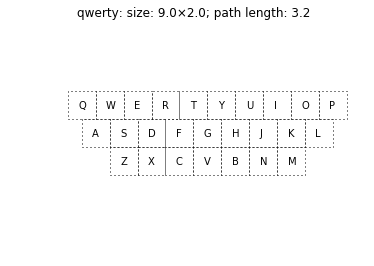

In [23]:
show_kbd(qwerty, 'qwerty')

Question 4: Keyboard with Minimal Workload Average?
===

Now for a much harder question: can we find a different keyboard layout that has a smaller average segment length over the workload? First, let's note that there are two ways to modify a keyboard:  

* Keep the keys in the same locations but swap letters. (This is an operation you can do on a physical keyboard just by prying off the key caps and swapping them.) 
* Change the locations of keys.  (On a physical keyboard you'd need a saw and glue to do this, but it is easier on a virtual keyboard.)  

Let's start by limiting ourselves to just swapping letters.  

This is an **optimization** problem.  There are many permutations of letters; too many to try them all. To be precise, there are 26! (26 factorial) permutations, which is about 10<sup>26</sup> (fun fact: 25 and 26 are the only integers for which n! &approx; 10<sup>n</sup>).  If we can't try them all, we need some way to sample the configurations, trying to make progress towards a better one. Again, we'll try the simplest thing that could possibly work: 

  1. Pick two keys at random.
  2. Swap them.
  3. If that gives a better (lower) workload total, keep them that way.
  4. If not, swap back.
  5. Repeat this for a given number of times, say 1000.

In [24]:
def improved(kbd, swaps=1000, scorer=workload_average):
    "Minimize scorer(kbd) by swapping keys and keeping improvements."
    kbd = kbd.copy()
    score = scorer(kbd)
    letters = list(kbd)
    for _ in range(swaps):
        A, B = random.sample(letters, 2)   # Step 1: pick two keys
        swap(kbd, A, B)                    # Step 2: swap them
        score2 = scorer(kbd)
        if score2 < score:                 # Step 3: If better, keep them
            score = score2                 # (and record the new best total)
        else:
            swap(kbd, B, A)                # Step 4: swap back if not better
    return kbd

def swap(kbd, A, B): kbd[A], kbd[B] = kbd[B], kbd[A]

**Note 1:** This strategy is called **hillclimbing**, drawing on the metaphor of getting to a high peak by trying to take a step, and continuing if the step is uphill, and returning if it is not.  This technique often finds a local maximum&mdash;a solution that is better than all its neighbors, but not as good as another solution that is many steps away.

**Note 2:** I make `scorer` be a parameter, in case we later decide we want to minimize something else other than `workload_average`.

Let's see how well we can do:

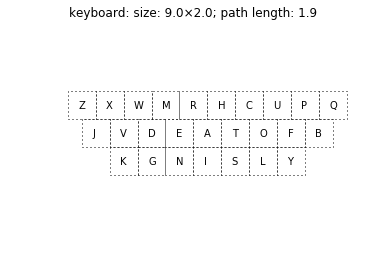

In [25]:
show_kbd(improved(qwerty, 3000))

That's a pretty good improvement! We decreased the workload average  by about a third. (If you are reading this in an active IPython notebook, you can re-run the cell above and see a different result each time.) 

Visualizing `improved`
---

Let's get a better feeling for what `improved` does.  We will keep track of the workload average after each swap, and plot that as a curve. We will repeat that 10 times (because each run has random variation).

I'll add another parameter, `scores`, to `improved`, If it is not `None`, then it should be a list into which we can accumulate all the scores (after each time step). Then I'll add a new function, `plot_improvements`, that plots the scores that `improved` accumulates.

In [26]:
def improved(kbd, swaps=1000, scorer=workload_average, scores=[]):
    "Minimize scorer(kbd) by swapping keys and keeping improvements."
    kbd = kbd.copy()
    score = scorer(kbd)
    letters = list(kbd)
    for _ in range(swaps):
        A, B = random.sample(letters, 2)   # Step 1: pick two keys
        swap(kbd, A, B)                    # Step 2: swap them
        score2 = scorer(kbd)
        if score2 < score:                 # Step 3: If better, keep them
            score = score2                 # (and record the new best total)
        else:
            swap(kbd, B, A)                # Step 4: swap back if not better
        scores.append(score)               # <<< NEW
    return kbd

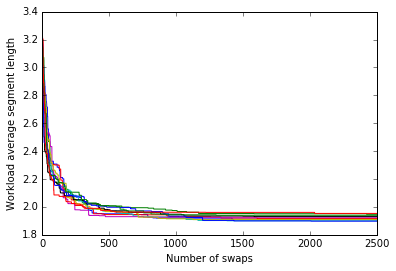

In [27]:
def plot_improvements(kbd, swaps, scorer=workload_average, repeats=10):
    plt.ylabel('Workload average segment length') 
    plt.xlabel('Number of swaps');  
    for _ in range(repeats):
        scores = []
        improved(kbd.copy(), swaps, scorer, scores)
        plt.plot(scores)
    plt.show()
    
plot_improvements(qwerty, 2500)

This plot is interesting. I note the following:

* Each curve follows a slightly different path (because the swaps are random).
* The curves are grouped very tightly together; the variance is small.  Almost everywhere, the difference between the best and the worst is about 0.2 or less. By the end, almost all the curves are between 1.9 and 2.0.
* We make rapid progress, decreasing from 3.2 to around 2.2 in about 200 swaps, and to around 2.0 in about 500 swaps.
* After 1000 swaps, progress is slow, and after 2000, even slower.

I can't say we've found the best possible keyboard, but it looks like progress will be slow in improving over about 1.9. 

Keys in Different Physical Locations
---

Now let's allow keys  to be in different physical locations.  Rather than allowing complete freedom of movement, we'll start from a few different fixed key layouts and swap keys from there. I'll define three layouts and gather them into a `dict`:

In [28]:
keyboards = {
    'qwerty': Keyboard(('Q W E R T Y U I O P',
                        ' A S D F G H J K L ',  
                        '   Z X C V B N M   ')),

    '4-by-7': Keyboard((' A B C D E F ',
                        'G H I J K L M',
                        ' N O P Q R S ',
                        'T U V W X Y Z')),

    '5-by-6': Keyboard((' A B C D E ',
                        'F G H I J K',
                        'L M N O P Q',
                        ' R S T U V',
                        '  W X Y Z '))
    }

Here is a function to report on a collection of keyboards such as this (after improving them):

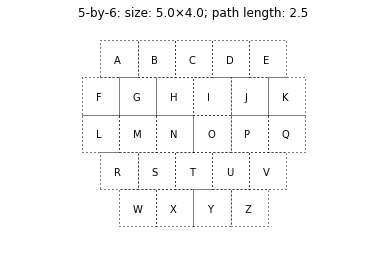

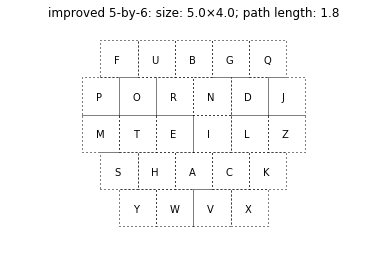

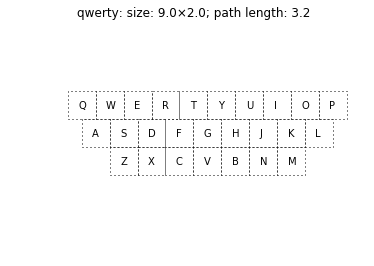

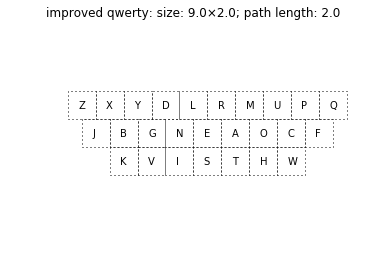

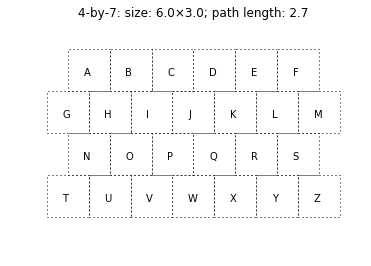

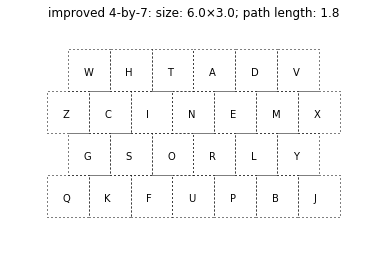

In [29]:
def report(keyboards=keyboards, swaps=3000, scorer=workload_average):
    "Iterate through a dict of {name: kbd} pairs, showing kbd before and after improved(kbd)."
    for (name, kbd) in keyboards.items():
        show_kbd(kbd, name)
        show_kbd(improved(kbd, swaps=swaps, scorer=scorer), 'improved ' + name)
        
report()

(**Note:** The plots of different-shaped keyboards have different-sized squares around the keys. Some of the plots have a lot of whitespace around them. If anyone knows an easy way to tell `plot` to display them better, let me know.)



So the more compact keyboards with a smaller diameter (`4-by-7` and `5-by-6`) seem to perform slightly better than `qwerty`. 


Question 5: How often are two words confused because of similar paths?
===

When can one word be confused with another?  When their paths are similar (which means that their corresponding letters are in similar locations). For example, on a Qwerty keyboard, the paths for "HELLO" and "JELLO" are similar, because **H** and **J** are adjacent, and the other letters are the same.

<img src="http://norvig.com/gesture.png">

We'd like to know, for a given keyboard, how confusing is it? How many words have paths on the keyboard that can be confused for other words? We have our work cut out for us:

1. Determine what letters could be confused for each other.
2. Determine what words/paths can be confused.
3. Invent some metric for the overall confusingness of a keyboard. 
4. Try to find less-confusing keyboards.

Letter Confusions
---

So, as a first step, we will make a mapping from each key to the keys that it can be confused with. I'll say that any key within a distance of 1.5 units on the keyboard is a **neighboring** key, and thus a potential confusion:

In [30]:
def neighboring_keys(kbd, radius=1.5):
    "Build a dict of {Letter:NeighboringLetters}, e.g. {'Q':'AQW', ...}."
    return {A: cat(sorted(B for B in kbd if distance(kbd[A], kbd[B]) <= radius))
            for A in kbd}

cat = ''.join  ## Function to join letters (or strings) into one string

In [31]:
qwerty_neighbors = neighboring_keys(qwerty) 
qwerty_neighbors

{'A': 'AQSWZ',
 'B': 'BGHJNV',
 'C': 'CDFGVX',
 'D': 'CDEFRSXZ',
 'E': 'DERSW',
 'F': 'CDFGRTVX',
 'G': 'BCFGHTVY',
 'H': 'BGHJNUVY',
 'I': 'IJKOU',
 'J': 'BHIJKMNU',
 'K': 'IJKLMNO',
 'L': 'KLMOP',
 'M': 'JKLMN',
 'N': 'BHJKMN',
 'O': 'IKLOP',
 'P': 'LOP',
 'Q': 'AQW',
 'R': 'DEFRT',
 'S': 'ADESWXZ',
 'T': 'FGRTY',
 'U': 'HIJUY',
 'V': 'BCFGHV',
 'W': 'AEQSW',
 'X': 'CDFSXZ',
 'Y': 'GHTUY',
 'Z': 'ADSXZ'}

We see, for example, that **Q**, off in the corner, has only **A**, **W**, and itself as neighbors, while **G**, in the middle of the keyboard, has 8 neighbors. 

Word Confusions
---

Consider each of the letters in the word "HELLO," and all the possible choices for neighbors of each letter:

In [32]:
columns = [qwerty_neighbors[L] for L in 'HELLO']
columns

['BGHJNUVY', 'DERSW', 'KLMOP', 'KLMOP', 'IKLOP']

These are five columns of letters, and if we pick one letter from each column, we get a path that is formed by letters that are each confusions of letters in the original word, and so the whole path is a confusion for the original word.  So "JELLO" is a confusion for "HELLO", as would be "BDKKI" and "YWPPP", except those are not words.

It turns out that there is a library function, `itertools.product`, that will take alternative choices, and generate all possible ways of assembling a sequence consisting of one selection (letter) from each alternative choice.

In [33]:
paths = {cat(picks) for picks in itertools.product(*columns)}

How many paths are there?

In [34]:
len(paths)

5000

Let's look at a few of them:

In [35]:
random.sample(paths, 8)

['NELKI', 'NWLKL', 'VEMKI', 'VEOOP', 'UWPMK', 'JSLML', 'GRMMO', 'UWKKP']

And let's see all the paths that are also words:

In [36]:
WORDS & paths

{'BROMO', 'BROOK', 'HELLO', 'JELLO'}

Only 4 out of 5000;  That's pretty good, but it means "HELLO" is still a confusing word. We can package this as the function  `confusions`:

In [37]:
def confusions(word, neighbors=neighboring_keys(qwerty)):
    "All valid words whose paths could be confused with the path for the given word."
    columns = [neighbors[L] for L in word]
    return {cat(picks) for picks in itertools.product(*columns)} & WORDS

In [38]:
confusions('HELLO')

{'BROMO', 'BROOK', 'HELLO', 'JELLO'}

In [39]:
confusions('WORLD')

{'ALTOS', 'EIDOS', 'SIDLE', 'SKEPS', 'WIELD', 'WORKS', 'WORLD', 'WORMS'}

In [40]:
confusions('TESTING')

{'FEARING',
 'FRAYING',
 'GEARING',
 'GRATING',
 'GRAYING',
 'GREYING',
 'REARING',
 'REEFING',
 'RESTING',
 'TEARING',
 'TESTING'}

So far, so good.  But I'm worried about the efficiency of `confusions`.

My first concern is that `WORDS` has 178,691 words, including many unusual words, so there might be too many confusions. I will read in a smaller word set, with only common words:

In [41]:
! [ -e words.js ] || curl -O https://xkcd.com/simplewriter/words.js
    
COMMON = set(re.findall('[A-Z]+', open('words.js').read().upper()))

In [42]:
len(COMMON), max(COMMON, key=path_length), max(COMMON, key=len)

(3614, 'SPECIALS', 'UNDERSTANDINGS')

More Efficient `confusions`
---

Another issue is that `confusions` is really slow:

In [43]:
%time confusions('SOMETHING')

CPU times: user 3.12 s, sys: 395 ms, total: 3.51 s
Wall time: 3.52 s


{'SOMETHING'}

It took (on my computer) 3 seconds to compute this.  Why so long? Let's count:

In [44]:
[len(neighboring_keys(qwerty)[L]) for L in 'SOMETHING']

[7, 5, 5, 5, 5, 8, 5, 6, 8]

There are 7 &times; 5 &times; 5 &times; 5 &times; 5 &times; 8 &times; 5 &times; 6 &times; 8 = 8,400,000 paths for `confusions` to consider. `'PALEOMAGNETISMS'` would have about 10,000 times more paths. Looking at every path is slow, but for most paths, we're wasting our time.  For example, one choice for the first two neighboring letters of 'SO' is 'XP', but 'XP' does not start any word in the dictionary.  Nevertheless, `itertools.product` will generate 240,000 combinations that start with 'XP', and will then rule them out one at a time. It would be better to stop as soon as we see 'XP', and never consider continuations of this path.

So that gives us the key idea for a more efficient version of `confusions`: *only follow paths that form a prefix of some word.*  I'll make a set of all the prefixes of the `COMMON` words:

In [45]:
def prefixes(words):
    "Return a set of prefixes (1 to N characters) of this collection of words."
    return {word[:i] for word in words for i in range(1, len(word)+1)}

PREFIXES = prefixes(COMMON)

In [46]:
prefixes(['THESE', 'THEY', 'THOSE'])

{'T', 'TH', 'THE', 'THES', 'THESE', 'THEY', 'THO', 'THOS', 'THOSE'}

We can describe the more efficient version of the `confusions` algorithm:

1. Maintain a queue of partial paths, where a partial path is a string representing choices for neighboring letters for a prefix of the word. For example, 'HE' and 'JE' are both partial paths for the word 'HELLO'.  Initialize the queue to have just one partial path, the empty string.
2. Remove a partial path from the queue. Find all possible ways to extend the path by adding a neighboring letter, but only if doing so creates a path that is a prefix of some word in the dictionary.  For example, given the word 'HELLO', and the partial path 'JE', consider all the neighbors of 'L' (namely, 'K', 'M', 'L', 'O', or 'P'), but only 'JEM', 'JEL', and 'JEO' are prefixes of words, so add just those to the queue.
3. When a partial path reaches the same length as the word ('HELLO' in this example), then don't extend it any farther; instead check to see if the path is a word.  If it is, yield it as a result.

A word is `confusable` if it has a confusion word (other than itself).

In [47]:
def confusions(word, neighbors=neighboring_keys(qwerty)):
    "All valid words whose paths could be confused with the path for this word."
    Q = ['']        # A queue of partial paths 
    while Q:
        path = Q.pop()
        if len(path) < len(word):
            for L in neighbors[word[len(path)]]:
                if path + L in PREFIXES:
                    Q.append(path + L)
        elif path in COMMON:
            yield path

def confusable(word, neighbors=neighboring_keys(qwerty)) -> bool: 
    "Is this word confusable with another, given this keyboard's neighboring keys?"
    return any(c != word for c in confusions(word, neighbors))

Let's check the speed (remember the old version took over 3 seconds):

In [48]:
%time set(confusions('SOMETHING'))

CPU times: user 119 µs, sys: 0 ns, total: 119 µs
Wall time: 122 µs


{'SOMETHING'}

We went from about 3 seconds to about 100 microseconds: that's 30,000 times faster!  We can look at some more confusions:

In [49]:
{w: ' '.join(confusions(w))
 for w in random.sample(COMMON, 30)}

{'A': 'S A',
 'ACCEPT': 'ACCEPT',
 'AIRS': 'WORE WORD WIFE WIDE SURE SITS SIRS SIDE AIRS',
 'BEATER': 'NEARER NEARED HEATER HEATED GRAYER GRAYED BESTED BEATER',
 'BEGAN': 'BEGAN',
 'BLOWER': 'NOISED BLOWER',
 'DISCOVERS': 'DISCOVERS',
 'DRINK': 'DRUNK DRINK',
 'DROVES': 'DROVES DRIVES',
 'ENTER': 'ENTER',
 'EXCEPT': 'EXCEPT',
 'GATHER': 'GATHER FATHER BAGGER BAGGED',
 'GUESSING': 'GUESSING',
 'LEADINGS': 'LEADINGS',
 'LOOKER': 'POOLED MOONED LOOKER LOOKED KILLER KILLED',
 'MAPS': 'MAPS',
 'NEEDED': 'NEEDED BEDDED',
 'NIGHTS': 'NIGHTS MIGHTS',
 'RETURNS': 'RETURNS',
 'ROOMED': 'ROOMED ROLLED FILLED',
 'SEXING': 'SEXING ADDING',
 'SHORTEST': 'SHORTEST',
 'SHOVING': 'SHOVING',
 'SKINNED': 'SKINNED',
 'SOUND': 'WOUND SPINS SOUND SKINS',
 'STOPS': 'STOPS STOOD STOLE DROPS',
 'THANKS': 'THANKS',
 'TRIPE': 'TRIPS TRIPE',
 'TV': 'TV',
 'VIEWED': 'VIEWED HORSES'}

Visualizing Paths on a Keyboard
----

It would be nice to see potentially confusable word paths on a keyboard.
I'll add a call to `plot_paths` in `show_kbd`:



In [50]:
def show_kbd(kbd, name='keyboard', words=()):
    "Plot the keyboard and show title/stats."
    for L in kbd:
        plot_square(kbd[L].x, -kbd[L].y, label=L)
    plot_paths(kbd, words)
    plt.axis('equal'); plt.axis('off')
    plt.title(title(kbd, name));
    plt.show()
    
def plot_paths(kbd, words):
    "Plot paths for each word."
    for (i, word) in enumerate(words):
        Xs = [kbd[L].x for L in word]
        Ys = [-kbd[L].y for L in word]
        plt.plot(Xs, Ys, '-o')

Let's see how it works on three similar paths:

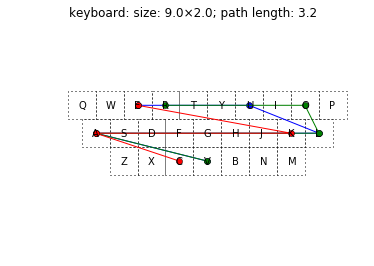

In [51]:
show_kbd(qwerty, words=['VALUE', 'VALOR', 'CAKE'])

 OK, we're on the right track, but I see three problems, which I think I can solve: 

- The letters are obscured by the circles.  Solution: offset paths away from the center.
- When the paths are the same, they overwrite each other.  Solution: offset each path towards a different corner.
- There is no indication what direction the path is going in. Solution: put a black square on the start position.



In [52]:
def plot_paths(kbd, words):
    "Plot paths for each word, each with a different offset (and color)."
    Q = 1/5  # Q originally meant a quarter of a key width; but 1/5 looks nicer.
    offsets = [Point(-Q, -Q), Point(-Q, +Q),  Point(Q, +Q), Point(Q, -Q)]
    for (i, word) in enumerate(words):
        Xs = [kbd[L].x + offsets[i % 4].x for L in word]
        Ys = [-kbd[L].y + offsets[i % 4].y for L in word]
        plt.plot(Xs, Ys, '-o')
        plt.plot(Xs[:1], Ys[:1], 'ks')

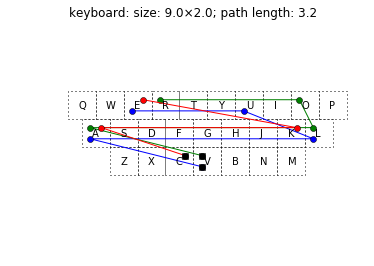

In [53]:
show_kbd(qwerty, words=['VALUE', 'VALOR', 'CAKE'])

That looks busier, but it is  easier to follow the paths. Another example:

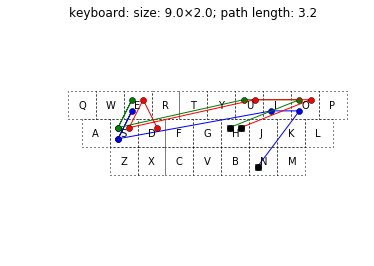

In [54]:
show_kbd(qwerty, words={'HOUSED', 'HOUSES', 'NOISES'})

Average Confusions of a Keyboard
===

The question is: how confusing is a keyboard? One metric for confusingness is the percentage of words that are confused with other words:

In [55]:
def confusingness(kbd):
    "The proportion of words in COMMON that are confused with other words on this keyboard."
    neighbors = neighboring_keys(kbd)
    return mean([confusable(w, neighbors) for w in COMMON])

    
def title(kbd, name): 
    X, Y = span(kbd[L].x for L in kbd), span(kbd[L].y for L in kbd)
    return ('{}: size: {:.1f}×{:.1f}; path length: {:.1f}; confusingness = {:.0%}'
            .format(name, X, Y, workload_average(kbd), confusingness(kbd)))


In [56]:
{name: confusingness(kbd) for (name, kbd) in keyboards.items()}

{'4-by-7': 0.4571112340896514,
 '5-by-6': 0.5282235749861649,
 'qwerty': 0.5398450470392916}

About half the common words are confusable, with a little bit of variation between keyboards.

Question 6: Is there a Keyboard that Minimizes Confusion?
===

Consider this:

In [57]:
%time confusingness(qwerty)

CPU times: user 134 ms, sys: 3.99 ms, total: 138 ms
Wall time: 143 ms


0.5398450470392916

In [58]:
%time workload_average(qwerty)

CPU times: user 188 µs, sys: 3 µs, total: 191 µs
Wall time: 202 µs


3.2333097802127653

Computing `confusingness` takes about 500 times longer than computing `workload_average`, so if we want to use `confusingness` as a scoring function, we will have to settle for fewer swaps:

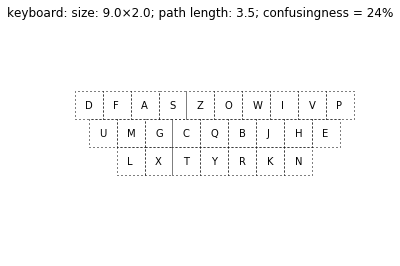

CPU times: user 10.6 s, sys: 26.7 ms, total: 10.6 s
Wall time: 10.6 s


In [59]:
%time show_kbd(improved(qwerty, swaps=100, scorer=confusingness))

This did indeed reduce confusingness (which was 54%); not bad for only 100 swaps.

Question 7: Is there a Keyboard that Maximizes User Satisfaction?
===

What is user satisfaction? I don't know, but for now I'll approximate satisfaction (or rather, *dissatisfaction*, since lower scores are better) with a combined score that is the product of workload average and confusingness. Then I (rather arbitrarily) scale the result by 5, just because I think a number like "2.1" looks better than "0.42".

First we'll define the combined scorer function and incorporate it into `title`:

In [60]:
def dissatisfaction(kbd, scale=5):
    "The product of workload average and confusingness, scaled."
    return scale * workload_average(kbd) * confusingness(kbd)

def title(kbd, name): 
    X, Y = span(kbd[L].x for L in kbd), span(kbd[L].y for L in kbd)
    return ('{}: size: {:.1f}×{:.1f}; path length: {:.1f}; confusingness: {:.0%}; overall: {:.1f}'
            .format(name, X, Y, workload_average(kbd), confusingness(kbd), dissatisfaction(kbd)))

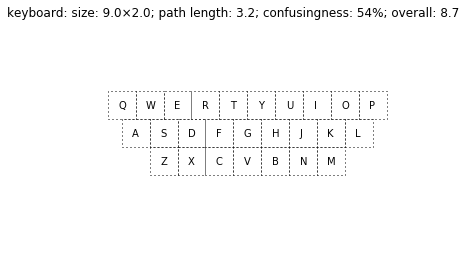

In [61]:
show_kbd(qwerty)

Now let's try to minimize confusion. This should take around 2 minutes:

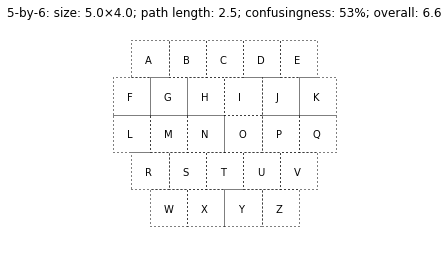

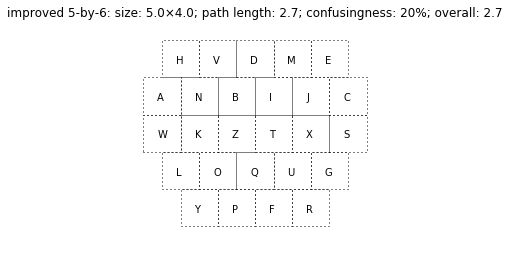

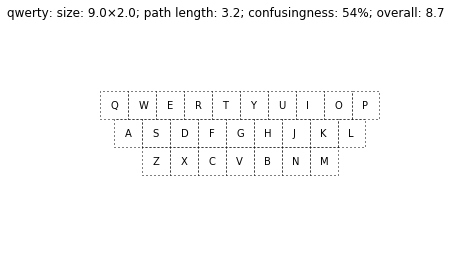

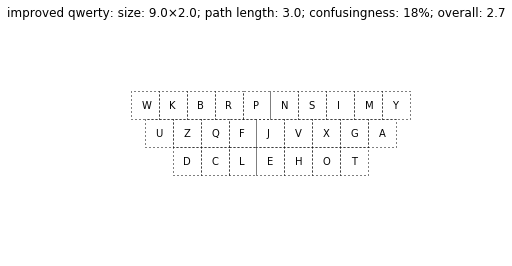

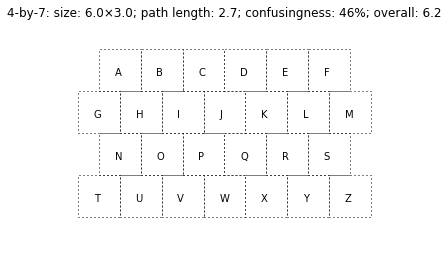

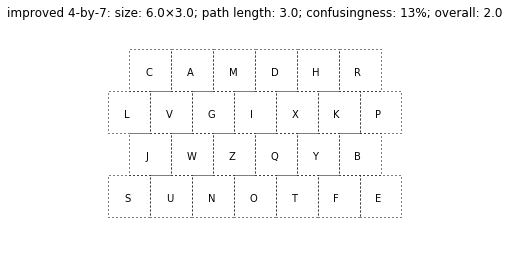

CPU times: user 2min 24s, sys: 188 ms, total: 2min 25s
Wall time: 2min 25s


In [62]:
%time report(swaps=500, scorer=dissatisfaction)

Success!  We were in fact able to make progress on the combined metric.  If we could run 50,000 swaps instead of just 500, we could probably do even better. To do so would require either (1) more computers, (2) more patience, or (3) more efficient algorithms.  I'll leave it up to you to make more progress.

**Note**: Each time this notebook is run, different random results can occur.  I'll record a keyboard found by one
of the good runs (only 11% confusingness) here, just in case another run is not as good:

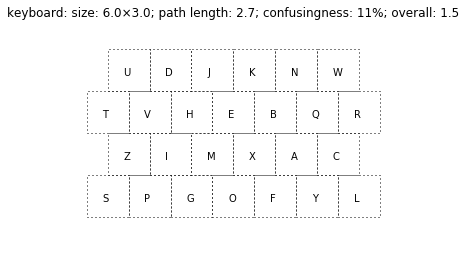

In [63]:
show_kbd(Keyboard((' U D J K N W ',
                   'T V H E B Q R',
                   ' Z I M X A C ',
                   'S P G O F Y L')))

# Bonus Question: What about the Keybee Keyboard?

In December 2017 the [Keybee keyboard](http://keybee.it/) was announced, claiming to cut the path length in half. The keyboard uses hexagonal keys:

![Keybee keyboard](http://keybee.it/img/phones/theme_002.png)

Let's see if we can replicate it. I'll give `keyboard` optional arguments to scale the (x, y) positions to get the proper hex grid layout (even though I will still draw each key with a square around it rather than a hexagon; I'll leave it to you to fix that if you want):

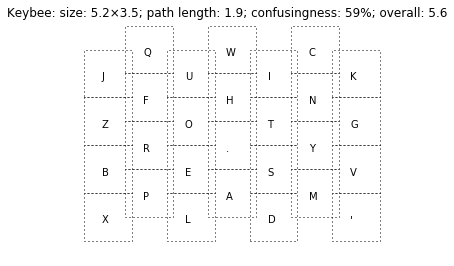

In [64]:
def Keyboard(rows, xscale=1/2, yscale=1):
    "A keyboard is a {letter: location} map, e.g. {'Q':Point(0, 0), 'A': Point(0.5, 1)}."
    return {ch: Point(xscale * x, yscale * y) 
            for (y, row) in enumerate(rows)
            for (x, ch) in enumerate(row)
            if ch != ' '}

def HexKeyboard(rows): return Keyboard(rows, xscale=(3 ** 0.5)/2, yscale=1/2)

keybee = HexKeyboard((
    ' Q W C ',
    'J U I K',
    ' F H N ',
    'Z O T G',
    ' R . Y ',
    'B E S V',
    ' P A M ',
    "X L D '"))

show_kbd(keybee, 'Keybee')

That's not pretty, but the keys are in the right places. The path length of 1.9 is better than the 3.2 for the QWERTY layout, but not twice as good, and not as good as some of the layouts we were able to achieve with square keys, and the advantage may be due to the fact that the keys overlap by 13%, not because the layout is especially clever. Can we improve the layout?

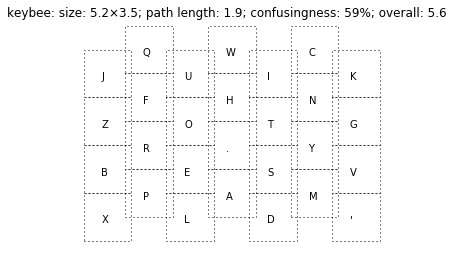

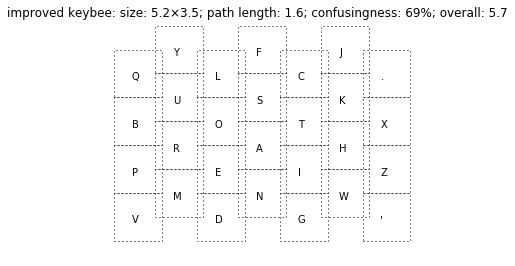

In [65]:
report({'keybee': keybee})

This does indeed cut the path length to
half of QWERTY, so maybe there is something to be said for hex grids. 
Note: the space  key was moved to the edge, because it doesn't contribute to the workload.
The Keybee FAQ says "the space key is the most important key on a keyboard," so clearly they are aiming
at two-thumb typing, not gesture typing; perhaps that's why it was so easy to improve their layout for our purposes.

Here is Keybee with some word paths:

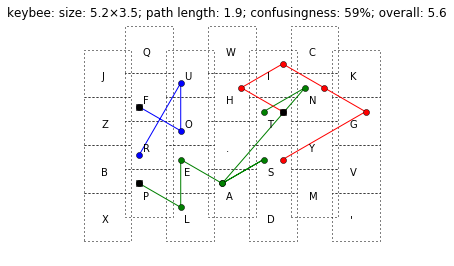

In [66]:
show_kbd(keybee, 'keybee', words=['FOUR', 'PLEASANT', 'THINGS'])

Summary
=====
  
  So where are we? Let's revisit our initial questions and see what answers we have:
  
 1. What words have the longest path length? <br>**Answered**: "PALEOMAGNETISMS" etc.
 2. What words have the highest ratio of path length to word length? <br>**Answered**: "PALAPA" etc.
 3. What is the average segment length, over a typical typing work load? <br>**Answered**: 3.23 keys, for Qwerty keyboard, on our sample workload.
 4. Is there a better keyboard layout to minimize the average segment length over a work load?  <br>**Answered**: Yes, many layouts at around 1.9 on Qwerty; or 1.7 or 1.8 on more square keyboards.
 5. How often are two words confused because they have similar paths? <br>**Answered**: On Qwerty, 26% of the words in a small dictionary, and 55% of the words in running text have at least one possible confusion. Other layouts are worse.
 6. Is there a better keyboard layout to minimize confusion? <br>**Partially Answered**: We found a keyboard with less confusingness than Qwerty.  The computation of confusingness takes too long to do very much hillclimbing search.  
 7. Is there a better keyboard layout to maximize overall user satisfaction? <br>**Partially Answered**: We defined a combined metric, and found
a keyboard with a better score. There are no doubt better metrics, and better keyboards to be found.
 



Going Beyond
===

Now it is your turn to answer the open questions, or make up some questions of your own.  Good luck! Here are a few ideas to get you started:

* Hillclimbing just keeps the one best keyboard it has found so far.  Other optimization techniques such as
[beam search](http://en.wikipedia.org/wiki/Beam_search) or [genetic algorithms](http://en.wikipedia.org/wiki/Genetic_algorithm)  or [ant colony optimization](http://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms) maintain several candidates at a time. Is that a good idea?

* The code in this notebook emphasizes clarity, not efficiency.  Can you modify the code (or perhaps port it to another language) and make it twice as efficient? 10 times? 100 times?

* What other factors do you think are important to user satisfaction with a keyboard.  Can you measure them?

* Consider the 5 paths below. They all start at 'P', move in a straight line to 'T', and then go to 'S', but they all make different stops along the top row. In other words, the 5 paths all trace exacty the same lines, so they are very confusing, but our definition of  `confusions` makes most of them different. Can you think
of a better way to handle confusions for paths like this?

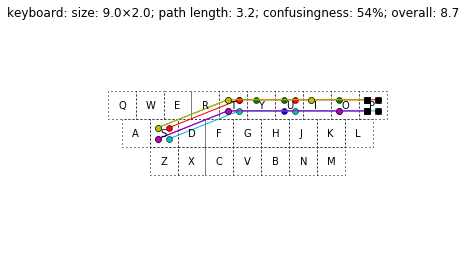

In [67]:
show_kbd(qwerty, words=['POUTS', 'POIUYTS', 'PUTTS', 'PUTS', 'POTS', 'PITS'])